## Введение в машинное обучение и NLP

При подготовке использовались материалы Екатерины Артемовой ( echernyak@hse.ru ) и Дарьи Самсоновой

In [1]:
from IPython.display import Image
from IPython.core.display import HTML

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

In [16]:
Image(url="https://static.tildacdn.com/tild3533-6161-4335-a633-643631363962/8.jpeg",
     width=800, height=400)

## Векторизация текстов

Чтобы работать с текстовыми данными, нам необходимо преобразовать текст в числа или вектораы. Это делается с помощью различных методов векторизации текстовых данных.

### Мешок слов  (Bag of words) 

Базовый способ векторизовать текст описывается метафорой "мешок слов" (bag-of-words). Представление мешка слов — это таблица с числами, в которой столбцы таблицы — уникальные слова, а строки — документы коллекции. В ячейках таблицы находится число вхождений слова в документ. Значит, в каждой строке получится набор чисел (он же вектор), характеризующий состав документа.

In [3]:
Image(url="https://i.ibb.co/r5Nc2HC/abs-bow.jpg",
     width=500, height=500)


Почему это называется мешок слов? Потому что при такой векторизации теряется порядок слов в документе (порядок слов в векторах один и тот же для всех векторов). Вместо последовательного текста получается неупорядоченный мешок отдельных слов.

На картинке выше частотность записана в абсолютных значениях. Лучше всегда использовать относительную частоту.

In [4]:
Image(url="https://i.ibb.co/47bRcVy/bow-normalized.jpg",
     width=500, height=500)

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [4]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

In [5]:
len(twenty_train.data)

2257

In [6]:
len(twenty_test.data)

1502

In [7]:
twenty_train.data[0]

'From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n'

In [8]:
vectorizer = CountVectorizer()
# в векторайзер нужно засовывать тексты строками (токенизация там встроена)
X = vectorizer.fit_transform(twenty_train.data)

## TF-IDF

Чтобы помочь нашей модели сфокусироваться на значимых словах, мы можем использовать скоринг TF-IDF (Term Frequency, Inverse Document Frequency) поверх нашей модели «мешка слов». TF-IDF взвешивает на основании того, насколько они редки в нашем датасете, понижая в приоритете слова, которые встречаются слишком часто и просто добавляют шум. Ниже приводится проекция метода главных компонент, позволяющая оценить наше новое представление.

In [17]:
Image(url="https://miro.medium.com/max/3604/1*qQgnyPLDIkUmeZKN2_ZWbQ.png",
     width=500, height=500)

In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(twenty_train.data)

In [10]:
X.shape
# первая размерность - количество документов
# вторая размерность - количесто слов в словаре

(2257, 35788)

In [18]:
twenty_train.data[0]

'From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n'

In [11]:
X

<2257x35788 sparse matrix of type '<class 'numpy.float64'>'
	with 365886 stored elements in Compressed Sparse Row format>


Слов получается в 5 раз больше, чем документов. Некоторые алгоритмы не смогут так обучиться (нужно чтобы количество признаков <= количество документов), а те что смогут будут обучаться сильно дольше. И учитывая, что большая часть слов встретились по 1 разу, они все равно никак не помогут.

In [12]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.4)
X = vectorizer.fit_transform(twenty_train.data)


В словаре у нас 7,5 тысяч слов и каждый документ мы описываем вектором такого размера. В этом векторе положительным будут значения, соответствующие словам, которые есть в этом тексте, а нулевыми - те значения, которые соответствуют словам, которых в тексте нет.
Нулевых значения будет значительно больше! Поэтому для эффективности в sklearn такие матрицы хранятся в специальном sparse (разреженном) формате.
Просто взять и посмотреть на матрицу не получится.

In [43]:
X

<2257x8566 sparse matrix of type '<class 'numpy.float64'>'
	with 258988 stored elements in Compressed Sparse Row format>


Мы векторизовали обучающую выборку, осталось векторизовать тестовую

Векторайзеры в sklearn имеют три основных метода **fit, transform и fit_transform**.

fit - собирает словарь и статистики по текстам,

transform - преобразует тексты в векторы, на основе уже собранного словаря.

fit_transform - делает сразу и первое и второе (быстре чем 1 и 2 по очереди).



In [48]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.4)
X = vectorizer.fit_transform(twenty_train.data)
X_test = vectorizer.transform(twenty_test.data)



# Классификация текстов




## Постановка задачи

* $d \in D$ – документы
* $c \in C$ – классы 


* Бинарная классификация: $C = \{0, 1\}$ 
* Многоклассовая классификация [multiclass classification]: $C = \{0, ..., K\}$
* Многотемная классификация [multi-label classification]: $C = \{0,1\}^K$

## Примеры

* Фильтрация спама: $C = \{spam, ham\}$ – бинарная классификация
* Классификация по тональности: $C =  \{neutral, positive, negative\}$ – классификация с тремя классами
* Рубрикация: $C \in \{религия, праздники, спорт, фестивали, ... \}$ – классификация на несколько тем
* Определение языка текста: $C \in \{Rus, Sr, Ukr, Bel, Kaz, Bul ... \}$
* Определение авторства:
    * Этим ли автором написан текст: $ C = \{0, 1\}$?
    * Кем из этих авторов написан текст: $ C = \{a_1, a_2, a_3, ... \}$?
    * Пол автора: $ C = \{f, m\}$


## Меры качества бинарной классификации 




In [19]:
Image(url="https://i.pinimg.com/originals/aa/91/7a/aa917a42422eaedb18224224519e48f0.jpg",
     width=500, height=500)

$precision = Pr =  \frac{tp}{tp+fp} $ – точность 

$recall = R = \frac{tp}{tp+fn} $ – полнота 

$F_2 = \frac{2 Pr * R}{Pr + R}$ – $F$-мера 

$accuracy = \frac{tp + tn}{tp + fp + fn + tn}$ –  аккуратность  

## Меры качества многоклассовой классификации 

<table>
  <tr>
    <th></th>
    <th></th>
    <th colspan="3">gold <br>standart</th>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>$class_1$</td>
    <td>$class_2$</td>
    <td>$class_3$</td>
  </tr>
  <tr>
    <td rowspan="3">classification <br>output</td>
    <td>$class_1$</td>
    <td>$tp_1$</td>
    <td>$fp_{12}$</td>
    <td>$fp_{13}$</td>
  </tr>
  <tr>
    <td>$class_2$</td>
    <td>$fn_{21}$</td>
    <td>$tp_2$</td>
    <td>$fp_{23}$</td>
  </tr>
  <tr>
    <td>$class_3$</td>
    <td>$fn_{31}$</td>
    <td>$fn_{32}$</td>
    <td>$tp_3$</td>
  </tr>
</table>


Микро-усреднение:

$micro-precision = $micro-Pr$ =  \frac{\sum tp_i}{\sum tp_i + \sum fp_i} $ 

$micro-recall = $micro-R$ = \frac{\sum tp_i}{\sum tp_i+ \sum fn_i } $

Макро-усреднение:

$macro-precision = $macro-Pr$ =  \frac{\sum Pr_i}{|C|} $

$macro-recall = $macro-R$ = \frac{\sum R_i}{|C|} $ 





### Вычисление расстояния / близости между документами 

Евклидово расстояние: $ dist( \vec{d_i}, \vec{d_j}) = \sqrt { \sum_{k} ( d_i^k - d_j^k)^2 }$

Косинусная мера близости: $ sim( \vec{d_i}, \vec{d_j}) =  \cos(\theta )=  \frac{ \vec{d_i}\cdot \vec{d_j} }{\| \vec{d_i} \|\|\vec{d_j} \|}$

## Метод ближайшего соседа  [Nearest neighbor classifier]

Найдем $k$ ближайших соседей (самых близких документов) для документа $d$. Посмотрим на то, каким классам относятся документы: выберем модальный класс – будем считать его классом $d$.





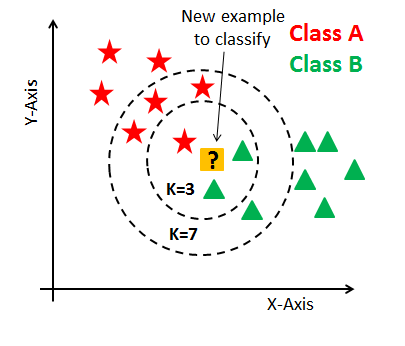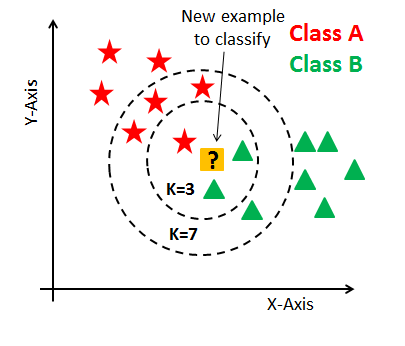

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data) #Learn the vocabulary dictionary and return term-document matrix.
X_train_counts.shape

(2257, 35788)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier().fit(X_train_counts, twenty_train.target)

In [15]:
from sklearn.metrics import *
twenty_test = fetch_20newsgroups(subset='test', categories=categories, 
                                 shuffle=True, random_state=0)
X_test = count_vect.transform(twenty_test.data) # Extract token counts out of raw text documents using the vocabulary fitted with fit 
print(X_test.shape)
predicted = clf.predict(X_test)

(1502, 35788)


In [16]:
acc = accuracy_score(predicted, twenty_test.target)
micro_f1 = f1_score(predicted, twenty_test.target, average = 'micro')
micro_p = precision_score(predicted, twenty_test.target, average = 'micro')
micro_r = recall_score(predicted, twenty_test.target, average = 'micro')
macro_f1 = f1_score(predicted, twenty_test.target, average = 'macro')
macro_p = precision_score(predicted, twenty_test.target, average = 'macro')
macro_r = recall_score(predicted, twenty_test.target, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.5599
micro F1=0.5599, micro P=0.5599, micro R=0.5599
macro F1=0.5507, macro P=0.5580, macro R=0.5963



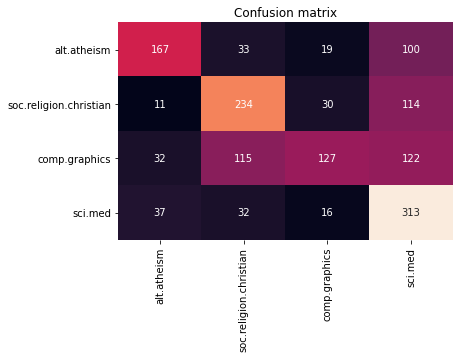

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.heatmap(data=confusion_matrix(twenty_test.target, predicted), annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

In [54]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new_counts = count_vect.transform(docs_new)
predicted = clf.predict(X_new_counts)

for doc, category in zip(docs_new, predicted):
    print('{} => {}'.format(doc, twenty_train.target_names[category]))

God is love => comp.graphics
OpenGL on the GPU is fast => comp.graphics


## Логистическая регрессия (метод максимальной энтропии [MaxEnt])

Требуется оценить вероятность принадлежности документа $d \in D$ классу $c \in C$: $p(c|d)$. Пусть заданы признаки  $f_i \in F$ – множество признаков и  $w_i$ – их веса. 

Признаки могут зависеть от классов: $f_i(c,d)$  

Линейная комбинация этих признаков: $\sum_{i=1}^k w_i f_i(c,d)$.  

Как связана $\sum_{i=1}^k w_i f_i(c,x)$ и $p(c|d)$?
	
$p(c|d) = \frac{1}{Z} e^{\sum_{i=1}^k w_i f_i(c,d)},$
	
где $\frac{1}{Z} = \frac{1}{\sum_{c' \in C} e^{\sum_{i=1}^k w_i f_i(c',d)} }.$

$ \widehat{c} = \texttt{argmax}_{c \in C} p (c|d) = \texttt{argmax}_{c \in C} \frac{e^{\sum_{i=1}^k w_i f_i(c,d)}}{\sum_{c' \in C} e^{\sum_{i=1}^k w_i f_i(c',d)}}  \propto  \texttt{argmax}_{c \in C} e^{\sum_{i=1}^k w_i f_i(c,d)}   \propto  \texttt{argmax}_{c \in C} \sum_{i=1}^k w_i f_i(c,d).  $


### Пример. Классификация по тональности на $C = <+,->$
	
Используем индикаторные признаки
	

*... there are virtually no surprises, and the writing is second-rate. So why did I enjoy it so much? For one thing, the cast is great ...*
	 

<table>
  <tr>
    <th>признак</th>
    <th>значение</th>
    <th></th>
    <th>вес</th>
  </tr>
  <tr>
    <td>$f_1$</td>
    <td>1</td>
    <td> "great" $\in d$ и $c=+$</td>
    <td rowspan="2">1.9</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>
  
   <tr>
    <td>$f_2$</td>
    <td>1</td>
    <td>"second-rate" $\in d$ и $c=-$</td>
    <td rowspan="2">0.9</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>

   <tr>
    <td>$f_3$</td>
    <td>1</td>
    <td>"no" $\in d$ и $c=-$ </td>
    <td rowspan="2">0.7</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>
  
   <tr>
    <td>$f_4$</td>
    <td>1</td>
    <td>"enjoy" $\in d$ и $c=-$ </td>
    <td rowspan="2">-0.8</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>

   <tr>
    <td>$f_4$</td>
    <td>1</td>
    <td>"great" $\in d$ и $c=-$ </td>
    <td rowspan="2">-0.6</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>




</table>
	






класс $+$:  $1.9 + 0 + 0 + 0 + 0 = 1.9$
	
класс $-$: $0 + 0.9 + 0.7 - 0.8 - 0.6 =0.2$

$p(+|d) = \frac{e^{1.9}}{e^{1.9}+e^{0.2}}$
	
$p(-|d) = \frac{e^{0.2}}{e^{1.9}+e^{0.2}}$

In [59]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train_counts, twenty_train.target)
predicted = clf.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
acc = accuracy_score(predicted, twenty_test.target)
micro_f1 = f1_score(predicted, twenty_test.target, average = 'micro')
micro_p = precision_score(predicted, twenty_test.target, average = 'micro')
micro_r = recall_score(predicted, twenty_test.target, average = 'micro')
macro_f1 = f1_score(predicted, twenty_test.target, average = 'macro')
macro_p = precision_score(predicted, twenty_test.target, average = 'macro')
macro_r = recall_score(predicted, twenty_test.target, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.8908
micro F1=0.8908, micro P=0.8908, micro R=0.8908
macro F1=0.8878, macro P=0.8868, macro R=0.8944



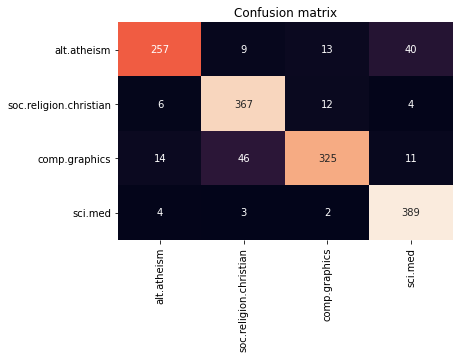

In [61]:
sns.heatmap(data=confusion_matrix(twenty_test.target, predicted), annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

In [62]:
predicted = clf.predict(X_new_counts)

for doc, category in zip(docs_new, predicted):
    print('{} => {}'.format(doc, twenty_train.target_names[category]))

God is love => soc.religion.christian
OpenGL on the GPU is fast => comp.graphics


## Деревья решений 



<img src="https://raw.githubusercontent.com/echernyak/ML-for-compling/d6b4f82e788cd7b365ea711db2ac4b0fc7a361d0/img/decision-tree.png" width="300" align='center'>

In [67]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train_counts, twenty_train.target)
predicted = clf.predict(X_test)

In [68]:
acc = accuracy_score(predicted, twenty_test.target)
micro_f1 = f1_score(predicted, twenty_test.target, average = 'micro')
micro_p = precision_score(predicted, twenty_test.target, average = 'micro')
micro_r = recall_score(predicted, twenty_test.target, average = 'micro')
macro_f1 = f1_score(predicted, twenty_test.target, average = 'macro')
macro_p = precision_score(predicted, twenty_test.target, average = 'macro')
macro_r = recall_score(predicted, twenty_test.target, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.7390
micro F1=0.7390, micro P=0.7390, micro R=0.7390
macro F1=0.7357, macro P=0.7363, macro R=0.7407



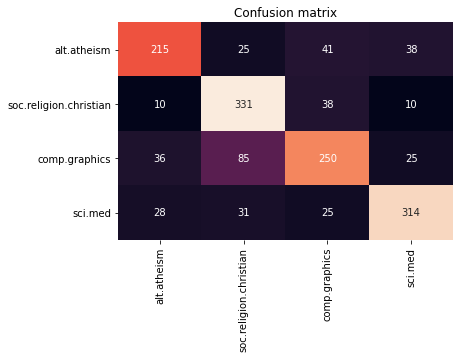

In [69]:
sns.heatmap(data=confusion_matrix(twenty_test.target, predicted), annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

# Отбор признаков



**Веса** :
* $tf-idf$, $\chi^2$ для взвешивания слов
* меры ассоциации биграм для отбора биграм: $(P)PMI$, $t-score$




**Уменьшение количества признаков**:
* лемматизация
* стемминг
* удаление стоп-слов
* пороги на частоту ($min\_tf$)
* пороги на документную частоту ($max\_df$)




**Признаки**:
* $n$-граммы 
* символьные $n$-граммы  (подслова, subwords)
* именованные сущности 
* термины
* "не\_" + слово 
* сохраним $N$ самых частых слов, остальные представим подсловами и символьными
$n$-грамами



**Снижение размерности**:
* скрытые темы в качестве признаков